In [8]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CovidPandemicForecasting')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install scipy --upgrade
import scipy
print(scipy.__version__)

1.7.3


In [4]:
import os
import gc
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

%matplotlib inline
#sns.set_theme(style='darkgrid')
#sns.set_palette('Set2', n_colors=10)
#plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
sns.set(rc={"figure.figsize":(8,4)})
sns.set_theme(style='white', palette='Set2', rc={"axes.spines.right": False, "axes.spines.top": False})
warnings.filterwarnings("ignore", module="matplotlib\..*")

# Statistics Importing

Os arquivos estão como `NomeDoModelo.csv` seguem uma formatação de resultado por métrica e município.

As colunas iniciam pelo `geocode`, para identificação do município, seguido de conjuntos de 4 colunas no formato `MÉTRICA_stats_curva`, onde *stats* pode ser `avg` para média ou `std` para desvio padrão, *curva* é a série temporal de `casos` ou `mortes`, e *métrica* é a sigla da função de loss usada.

In [9]:
# containers globais
METADATA = {}
VERTEX = pd.DataFrame()
STATS = pd.DataFrame()

# informações gerais sobre o dataset
def getExtraInfo(path):
    df = pd.read_csv(path + 'atrib_extra.csv')
    for atrib in df['atrib'].values:
        if atrib in ['data_inicio', 'data_termino']:
            continue
        METADATA[atrib] = int (df[ df['atrib']==atrib ]['valor'].values)
    return

# atributos estáticos dos municípios para as análises
def getVertexData(path):
    global VERTEX
    VERTEX = pd.read_csv(path + 'atrib_estat.csv')
    VERTEX.rename(inplace=True, columns={
        'geocodigo': 'geocode',
        'municipio': 'municipality',
        'estado': 'state',
        'area': 'area_km2',
        'populacao': 'population',
        'perimetro': 'perimeter',
        'leitos_hosp': 'h_beds'
    })
    VERTEX.insert(4, 'size_categ', [
        ('small' if p<15e3 else ('large' if p>=15e4 else 'medium')) 
        for p in VERTEX['population'].values 
    ])
    return

# estatísticas das métricas por modelo
# >> (container) >> (model) >> (metric) >> (curve) >> (statistic)
def getStatistics(path):
    global STATS
    STATS.drop(STATS.index, inplace=True)
    model_names = os.listdir(path)
    # obter os dados da planilha
    for file in model_names:
        model = file.split('.parquet.gzip')[0]
        df = pd.read_parquet(path + file)
        # mudança de tipo para reduzir o tamanho do objeto
        for c in df.columns[3:]:
            df[c] = df[c].astype(np.float32)
        df.insert(0,'forecaster',model)
        STATS = STATS.append(df, ignore_index=True)
    # aplicação da função ReLU na saída
    for col in STATS.columns[-2:]:
        #STATS[col] = np.maximum(STATS[col].values, 0)
        np.maximum(STATS[col].values, 0, STATS[col].values)
    return

In [10]:
getExtraInfo('GrafoBrasilCovid/dados/gerado/')
getVertexData('GrafoBrasilCovid/dados/gerado/')
getStatistics('statistics/')

In [11]:
VERTEX

,geocode,municipality,state,population,size_categ,xcoord,ycoord,area_km2,perimeter,h_beds
0,1100015,Alta Floresta D'Oeste,RO,22728,medium,-61.996482,-11.929466,7074.547776,653.606983,31
1,1100023,Ariquemes,RO,109523,medium,-63.033269,-9.908463,4390.850918,435.427786,142
2,1100031,Cabixi,RO,5188,small,-60.544666,-13.495098,1308.666714,196.977604,4
3,1100049,Cacoal,RO,85893,medium,-61.442944,-11.433865,3795.180484,320.034289,257
4,1100056,Cerejeiras,RO,16204,medium,-60.818653,-13.194416,2785.079094,382.335889,25
...,...,...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis,GO,13977,small,-48.506671,-16.745736,952.369228,192.584851,28
5566,5222054,Vicentinópolis,GO,8873,small,-49.807468,-17.730922,734.280378,193.684110,9
5567,5222203,Vila Boa,GO,6312,small,-47.052931,-15.034124,1064.486720,250.663737,7
5568,5222302,Vila Propício,GO,5882,small,-48.884897,-15.456882,2186.546234,334.645490,0


In [12]:
STATS

,forecaster,geocode,mb,fh,TARGET_cases,TARGET_deaths,OUTPUT_cases,OUTPUT_deaths
0,Naive-sp02,1100015,1,1,1.333333,1.000000e+00,1.333333,1.000000
1,Naive-sp02,1100023,1,1,10.666667,1.333333e+00,14.000000,1.333333
2,Naive-sp02,1100031,1,1,1.000000,1.000000e+00,1.000000,1.000000
3,Naive-sp02,1100049,1,1,2.000000,1.000000e+00,2.000000,1.000000
4,Naive-sp02,1100056,1,1,1.000000,1.000000e+00,1.000000,1.000000
...,...,...,...,...,...,...,...,...
19494995,stGCN-m1-f9,5222005,10,25,1.666667,7.450581e-09,1.610115,0.000000
19494996,stGCN-m1-f9,5222054,10,25,1.666667,7.450581e-09,0.194325,0.000000
19494997,stGCN-m1-f9,5222203,10,25,0.000000,7.450581e-09,0.000000,0.000000
19494998,stGCN-m1-f9,5222302,10,25,0.666667,7.450581e-09,0.000000,0.000000


In [13]:
set(STATS['forecaster'].values)

{'ARIMA-o100',
 'ExpSm-sp02',
 'Naive-sp02',
 'Naive-sp14',
 'stGCN-m1-f0',
 'stGCN-m1-f1',
 'stGCN-m1-f2',
 'stGCN-m1-f3',
 'stGCN-m1-f4',
 'stGCN-m1-f5',
 'stGCN-m1-f6',
 'stGCN-m1-f7',
 'stGCN-m1-f8',
 'stGCN-m1-f9'}

# Analytics Functions

In [14]:
def group_cv_results(template_list):
    global STATS
    grouped_df = pd.DataFrame()

    for template_name in template_list:
        model_prefix = template_name +  '-f'
        STATS.drop(STATS[ STATS['forecaster']==template_name ].index, inplace=True)
        qt_folds = STATS[ STATS['forecaster'].str.contains(model_prefix, case=False) ]['forecaster'].nunique()
        
        for i in range(qt_folds):
            name = model_prefix + str(i)
            mask = (STATS['forecaster'] == name) & (STATS['mb'] == i+1)
            df = pd.DataFrame(STATS[mask])
            df['forecaster'] = template_name
            grouped_df = grouped_df.append(df, ignore_index=True)
        
    STATS = STATS.append(grouped_df, ignore_index=True)
    return

In [15]:
def loss_MAE(output, target, reduce=True):
    err = np.abs(output - target)
    return err.mean() if reduce else err

def loss_MSE(output, target, reduce=True):
    err = (output - target)**2
    return err.mean() if reduce else err

def loss_MAPE(output, target, reduce=True):
    err = (np.abs(output - target) / (1 + np.abs(target)))
    return err.mean() if reduce else err

def loss_sMAPE(output, target, reduce=True):
    err = (np.abs(output - target) / (1 + np.abs(output) + np.abs(target)))
    return err.mean() if reduce else err

def loss_NRMSE(output, target, reduce=True):
    std = target.std()
    err = np.sqrt(loss_MSE(output,target,reduce)) / std if std else 0
    return err

LOSS = {
    'MAE':   loss_MAE,
    'sMAPE': loss_sMAPE,
    'NRMSE': loss_NRMSE,
}

CURVE = ['cases', 'deaths']

In [16]:
def mergeAttrib(col, trim, df=None):
    global STATS
    global VERTEX
    
    df = (STATS if df is None else df).merge(VERTEX[['geocode',col]], on='geocode')
    return df[col] if trim else df

In [17]:
def calcMetrics(by, reduce=True, normalize=False, source=None, family=False):
    global STATS
    global VERTEX
    global LOSS
    
    if source is None:
        source = STATS
    
    
    curves = ['_cases','_deaths']
    n = ('_100k' if normalize else '')
    metrics = [ str(l+c+n) for l in LOSS.keys() for c in curves ]
    data = {'forecaster':[]}
    
    if not reduce:
        data['geocode'] = []
    
    if normalize:
        hab100k = mergeAttrib('population', trim=True) / 100e3
    
    f_list = list(set(source['forecaster'].values))
    labels = {
        'model':'forecaster',
        'city':'municipality',
        'fold':'mb',
        'horizon':'fh',
        'size': 'size_categ',
        'state': 'state'
    }
    
    #######################################
    if by == 'model':
        data.update({ m:[] for m in metrics })
        
        for f in f_list:
            mask = (source['forecaster']==f).values
            
            if reduce:
                data['forecaster'].append(f)
            else:
                data['geocode'] += source[mask]['geocode'].tolist()
                data['forecaster'] += [ f for i in range(mask.sum()) ]
            
            if normalize:
                factor = hab100k[mask]['population'].values
            
            for c in curves:
                output = source[mask]['OUTPUT'+c].values
                target = source[mask]['TARGET'+c].values
                
                if normalize:
                    output /= factor
                    target /= factor
                    c += '_100k'
                
                for m,l in LOSS.items():
                    err = l(output, target, reduce)
                    if reduce:
                        data[m+c].append(err)
                    else:
                        try:
                            data[m+c] += list(err)
                        except:
                            print(m+c,':', len(data[m+c]))
                            return err
    
    #######################################
    elif by in ['fold','horizon']:
        key = labels[by]
        data.update({ m:[] for m in [key]+metrics })
        k_list = list(set(source[key].values))
        preloaded_mask = { f: (source['forecaster']==f) for f in f_list }
            
        for k in k_list:
            k_mask = (source[key]==k)
        
            for f in f_list:
                mask = (preloaded_mask[f] & k_mask).values
                
                if mask.sum()==0:
                    continue
                elif reduce:
                    data['forecaster'].append(f)
                    data[key].append(k)
                else:
                    rng = range(mask.sum())
                    data['geocode'] += source[mask]['geocode'].tolist()
                    data['forecaster'] += [ f for i in rng ]
                    data[key] += [ k for i in rng ]
            
                if normalize:
                    factor = hab100k[mask]['population'].values

                for c in curves:
                    output = source[mask]['OUTPUT'+c].values
                    target = source[mask]['TARGET'+c].values
                
                    if normalize:
                        output /= factor
                        target /= factor
                        c += '_100k'

                    for m,l in LOSS.items():
                        err = l(output, target, reduce)
                        if reduce:
                            data[m+c].append(err)
                        else:
                            data[m+c] += list(err)
    
    #######################################
    elif by in ['size','city','state']:
        key = labels[by]
        data.update({ m:[] for m in [key,'qtde'] + metrics })
        k_list = list(set(VERTEX[key].values))
        merged = mergeAttrib(key, trim=False, df=source)
        preloaded_mask = { f: (merged['forecaster']==f) for f in f_list }
        
        for k in k_list:
            k_mask = (merged[key]==k)
        
            for f in f_list:
                mask = (preloaded_mask[f] & k_mask).values
                
                if reduce:
                    qt = len(set(merged[mask]['geocode']))
                    data['forecaster'].append(f)
                    data['qtde'].append(qt)
                    data[key].append(k)
                else:
                    rng = range(mask.sum())
                    data['geocode'] += merged[mask]['geocode'].tolist()
                    data['forecaster'] += [ f for i in rng ]
                    data['qtde'] += [ 1 for i in rng ]
                    data[key] += [ k for i in rng ]
                
                if normalize:
                    factor = hab100k[mask]['population'].values

                for c in curves:
                    output = merged[mask]['OUTPUT'+c].values
                    target = merged[mask]['TARGET'+c].values
                
                    if normalize:
                        output /= factor
                        target /= factor
                        c += '_100k'

                    for m,l in LOSS.items():
                        err = l(output, target, reduce)
                        if reduce:
                            data[m+c].append(err)
                        else:
                            data[m+c] += list(err)
    #######################################
    else:
        return
    
    #######################################
    rev_dict = { v:k for k,v in labels.items() }
    df = pd.DataFrame(data).rename(columns=rev_dict)
    df.sort_values(by=['model',by], inplace=True, ignore_index=True)
    if family:
        df.insert(loc=1, column='family', value=[ m.rsplit('-',1)[0] for m in df['model'].values ])
    return df

# Results and Analysis

## Dataset Cleansing

In [21]:
IMG_PATH = 'images/error/'

In [22]:
# resultado médio por modelo
group_cv_results(['stGCN-m1'])
calcMetrics(by='model', normalize=False, reduce=True, family=True)

,model,family,MAE_cases,MAE_deaths,sMAPE_cases,sMAPE_deaths,NRMSE_cases,NRMSE_deaths
0,ARIMA-o100,ARIMA,3.931611,0.120556,0.194225,0.024212,0.646716,0.542475
1,ExpSm-sp02,ExpSm,4.814366,0.160990,0.218453,0.031456,0.896523,0.748693
2,Naive-sp02,Naive,4.204800,0.132079,0.191895,0.025451,0.650955,0.601353
3,Naive-sp14,Naive,4.340265,0.133784,0.198641,0.025872,0.671220,0.597576
4,stGCN-m1,stGCN,3.022284,0.084823,0.262283,0.034831,0.557524,0.528364
5,stGCN-m1-f0,stGCN-m1,4.028857,0.128748,0.342971,0.037384,0.657817,0.883735
6,stGCN-m1-f1,stGCN-m1,3.062271,0.083500,0.243024,0.035546,0.634478,0.446698
7,stGCN-m1-f2,stGCN-m1,2.737787,0.082163,0.216954,0.036446,0.580414,0.396613
8,stGCN-m1-f3,stGCN-m1,3.230246,0.079200,0.289484,0.032794,0.620826,0.423512
9,stGCN-m1-f4,stGCN-m1,2.635433,0.077667,0.260882,0.034075,0.489705,0.418673



<<< stGCN-m1 >>>



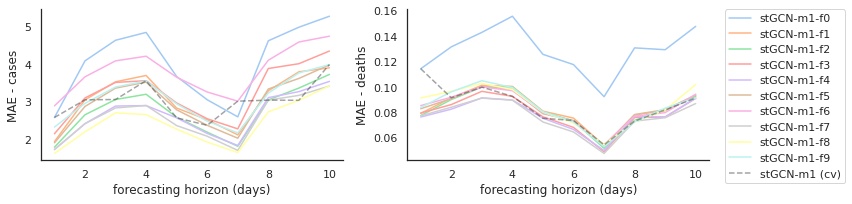

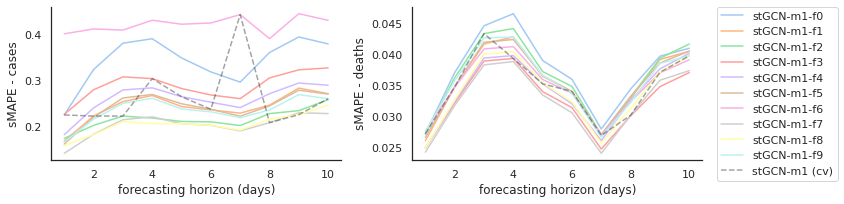

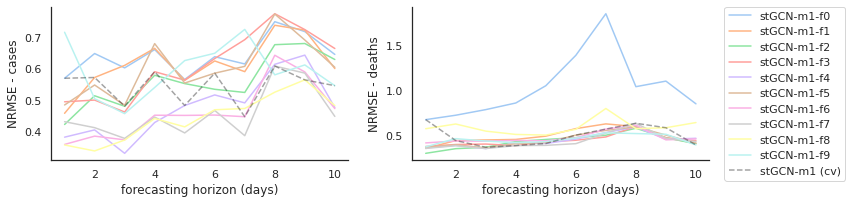

In [23]:
df = calcMetrics(by='fold', reduce=True, family=True)

for name in ['stGCN-m1']:
    print('\n<<< '+name+' >>>\n')
    f1 = df['family']==name
    f2 = df['model']==name

    for loss in ['MAE','sMAPE','NRMSE']:
        fig, axes = plt.subplots(1,2,figsize=(12,3))
        for i, curve in enumerate(['cases', 'deaths']):
            col = loss + '_' + curve
            sns.lineplot(
                x='fold', 
                y=col,
                hue='model',
                palette='pastel',
                data=df[f1],
                ax=axes[i]
            )
            axes[i].plot(
                df[f2]['fold'].values,
                df[f2][col].values,
                'k--',
                alpha=0.4,
                label = name + ' (cv)'
            )
            if not i:
                axes[i].legend().remove()
            else:
                axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
            axes[i].set(xlabel='forecasting horizon (days)')
            axes[i].set(ylabel=loss+' - '+curve)
        plt.tight_layout()
        plt.savefig(IMG_PATH+'fold_'+loss+'_'+name+'_[en].png', dpi=150)
        plt.show()

In [24]:
# dataset cleansing
getStatistics('statistics/')
group_cv_results(['stGCN-m1'])

models = ['stGCN-m1','Naive-sp02','ExpSm-sp02','ARIMA-o100']
mask = [ m not in models for m in STATS['forecaster'].values ]
proposed = 'Double Gated GCN'

STATS.drop(STATS.index[mask], inplace=True)
STATS.replace({
    'stGCN-m1'    : proposed,
    'ARIMA-o100'  : 'ARIMA',
    'ExpSm-sp02'  : 'Exp. Smoothing',
    'Naive-sp02'  : 'Naive Forecaster',
}, inplace=True)

proposed = 'Double Gated GCN'

In [25]:
#df_mun = calcMetrics(by='municipality')
#df_mun = df_mun.rename(columns={'municipality':'geocode'})
#df_mun = df_mun.merge(VERTEX[['geocode','size_categ','state']], on='geocode')

## A) By Inhabitants (municipality size)

Desempenho por município para as curvas de casos e mortes agrupados conforme a população absoluta do município.

In [17]:
# força o garbage collector
gc.collect()

df = calcMetrics(by='model')
df.insert(0,'size','all')
df.insert(1,'qtde','5570')
df = df.append(calcMetrics(by='size'), ignore_index=True)
df.sort_values(by=['qtde','model'], inplace=True, ignore_index=True)
df

,size,qtde,model,MAE_cases,MAE_deaths,sMAPE_cases,sMAPE_deaths,NRMSE_cases,NRMSE_deaths
0,large,201,ARIMA,47.145660,1.526967,0.324912,0.162443,0.685088,0.557347
1,large,201,Double Gated GCN,36.071800,1.159055,0.306713,0.188868,0.601536,0.549489
2,large,201,Exp. Smoothing,55.331955,1.850729,0.330003,0.202231,0.928996,0.690526
3,large,201,Naive Forecaster,48.843582,1.643589,0.307735,0.166499,0.684234,0.614483
4,medium,2119,ARIMA,4.514983,0.134800,0.273656,0.036935,0.919095,0.960563
5,medium,2119,Double Gated GCN,3.261420,0.088717,0.323794,0.055925,0.609958,0.717417
6,medium,2119,Exp. Smoothing,5.525307,0.188547,0.298516,0.047299,1.478911,2.736682
7,medium,2119,Naive Forecaster,4.841803,0.149155,0.258870,0.038764,0.993084,1.145649
8,small,3250,ARIMA,0.878630,0.024288,0.134353,0.007367,0.976361,1.040899
9,small,3250,Double Gated GCN,0.822384,0.015847,0.219431,0.011552,0.849413,0.905029


In [18]:
print(df.to_latex(float_format="%.3f", index=False))

\begin{tabular}{lllrrrrrr}
\toprule
  size & qtde &            model &  MAE\_cases &  MAE\_deaths &  sMAPE\_cases &  sMAPE\_deaths &  NRMSE\_cases &  NRMSE\_deaths \\
\midrule
 large &  201 &            ARIMA &     47.146 &       1.527 &        0.325 &         0.162 &        0.685 &         0.557 \\
 large &  201 & Double Gated GCN &     36.072 &       1.159 &        0.307 &         0.189 &        0.602 &         0.549 \\
 large &  201 &   Exp. Smoothing &     55.332 &       1.851 &        0.330 &         0.202 &        0.929 &         0.691 \\
 large &  201 & Naive Forecaster &     48.844 &       1.644 &        0.308 &         0.166 &        0.684 &         0.614 \\
medium & 2119 &            ARIMA &      4.515 &       0.135 &        0.274 &         0.037 &        0.919 &         0.961 \\
medium & 2119 & Double Gated GCN &      3.261 &       0.089 &        0.324 &         0.056 &        0.610 &         0.717 \\
medium & 2119 &   Exp. Smoothing &      5.525 &       0.189 &        0.299

In [19]:
# vai expandir em 3,4 GB (para a base completa) ou
# 2,1 GB (para a base reduzida) durante a execução
df = calcMetrics(by='size', reduce=False)
df.drop(columns=['qtde'], inplace=True)

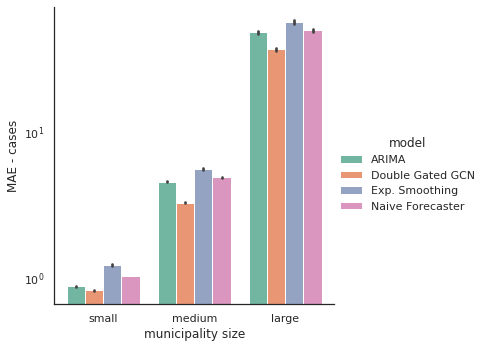

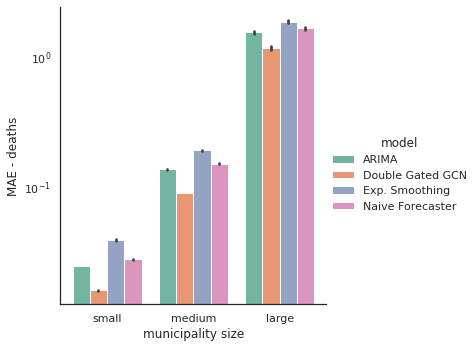

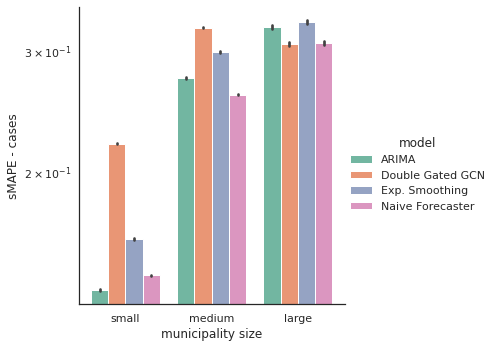

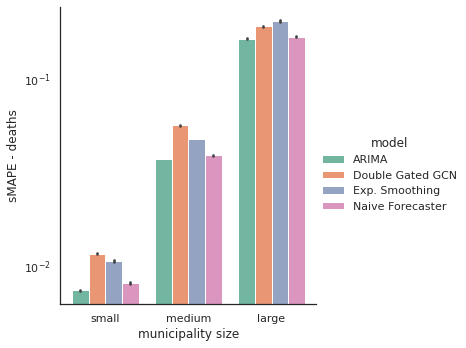

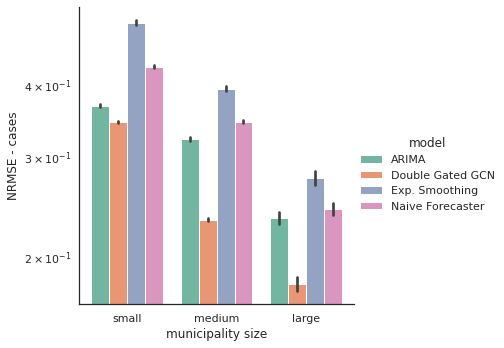

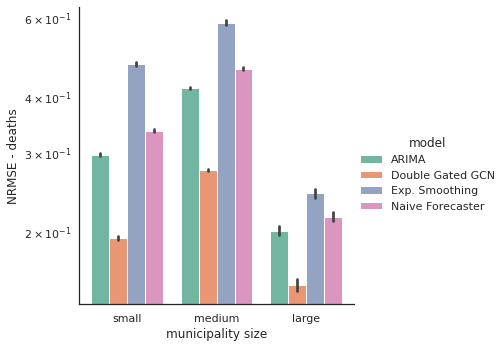

In [20]:
for loss in LOSS.keys():
    for curve in CURVE:
        col = loss+'_'+curve
        sns.catplot(
            x='size', 
            y=col,
            hue='model',
            kind='bar',
            ci=95,
            order=['small','medium','large'],
            palette='Set2',
            data=df
        )
        plt.xlabel('municipality size')
        plt.ylabel(loss+' - '+curve)
        #plt.ylim([5e-1, 1e2])
        plt.semilogy()
        plt.savefig(IMG_PATH+'size_'+col+'_[en].png', dpi=150)
        plt.show()

## B) By State

In [21]:
# força o garbage collector
gc.collect()

df = calcMetrics(by='state')
df.sort_values(by=['state','model'], inplace=True, ignore_index=True)
df

,model,state,qtde,MAE_cases,MAE_deaths,sMAPE_cases,sMAPE_deaths,NRMSE_cases,NRMSE_deaths
0,ARIMA,AC,22,5.132758,0.137095,0.275158,0.032191,0.623216,0.725864
1,Double Gated GCN,AC,22,4.055529,0.103309,0.328471,0.047419,0.579801,0.896369
2,Exp. Smoothing,AC,22,6.142025,0.154831,0.325221,0.036930,0.994128,0.717425
3,Naive Forecaster,AC,22,5.261455,0.133758,0.260561,0.031261,0.608236,0.676918
4,ARIMA,AL,102,3.197152,0.087173,0.220694,0.023050,0.626949,0.446481
...,...,...,...,...,...,...,...,...,...
103,Naive Forecaster,SP,645,6.022200,0.227338,0.199365,0.037851,0.533182,0.518092
104,ARIMA,TO,139,1.826811,0.045468,0.157933,0.012548,0.555134,0.827906
105,Double Gated GCN,TO,139,1.451887,0.028579,0.244029,0.018176,0.345518,0.609641
106,Exp. Smoothing,TO,139,2.316581,0.071981,0.182591,0.017696,0.776204,1.606899


In [22]:
#df_temp = df[ df['model']==proposed ][ df.columns[1:] ]
#print(df_temp.to_latex(float_format='%.3f', index=False))

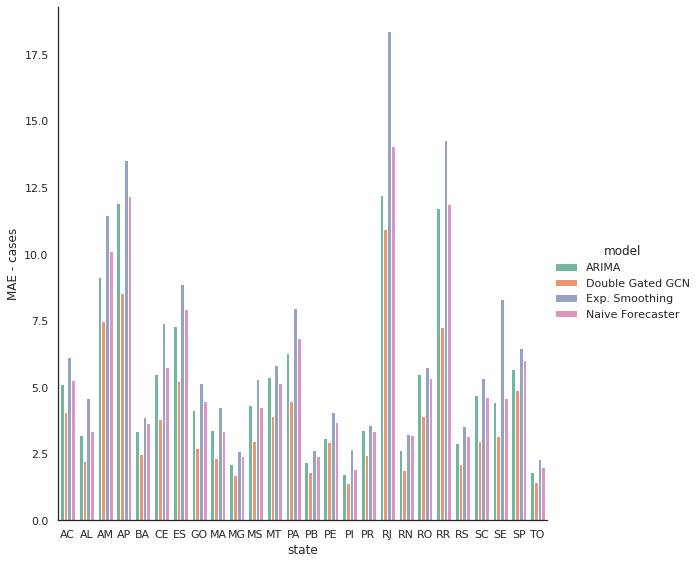

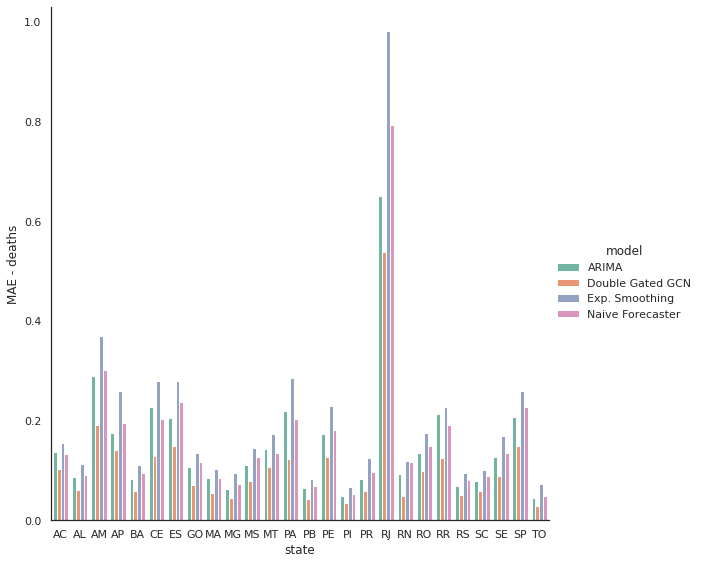

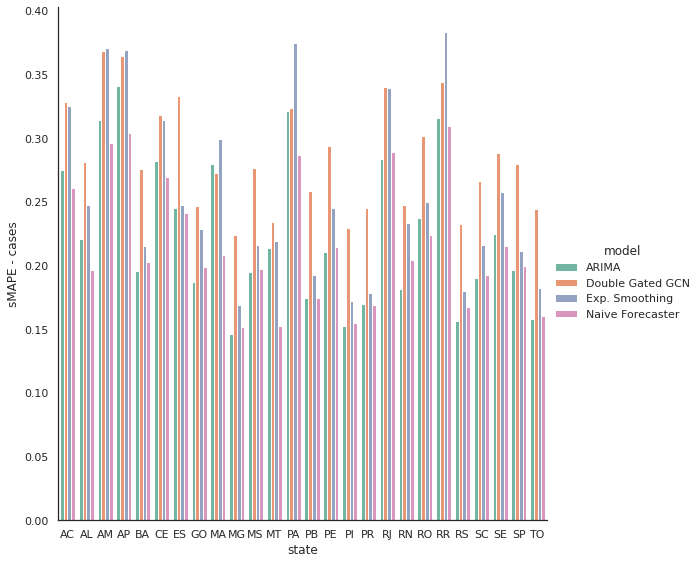

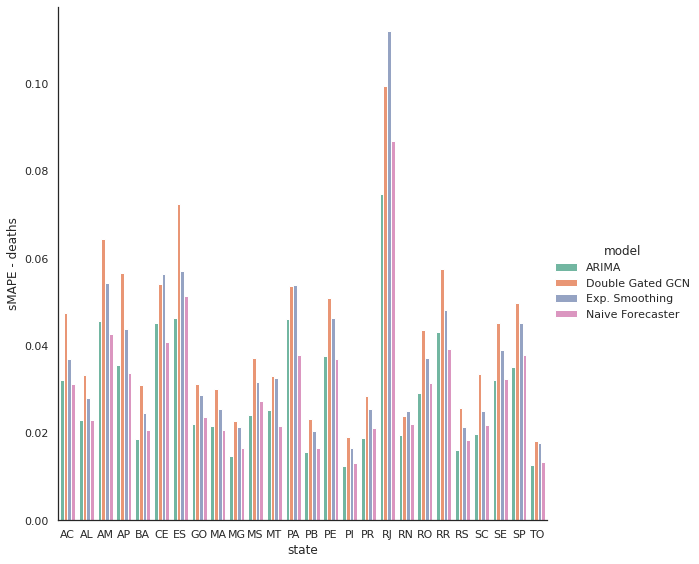

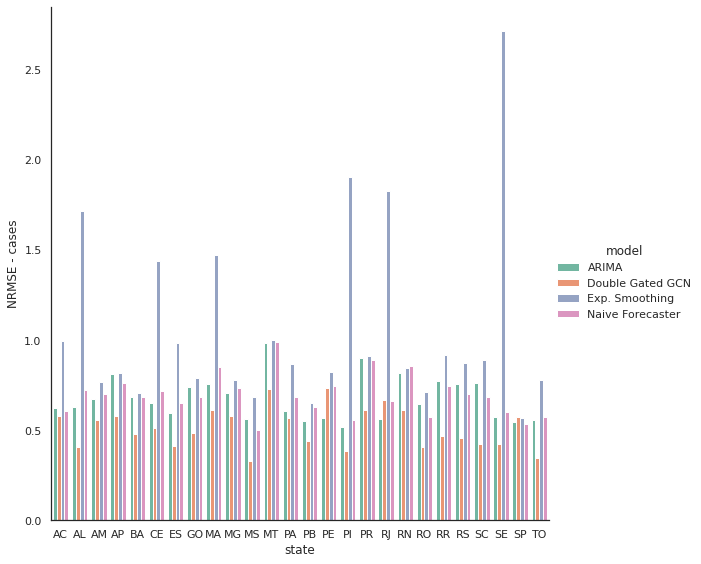

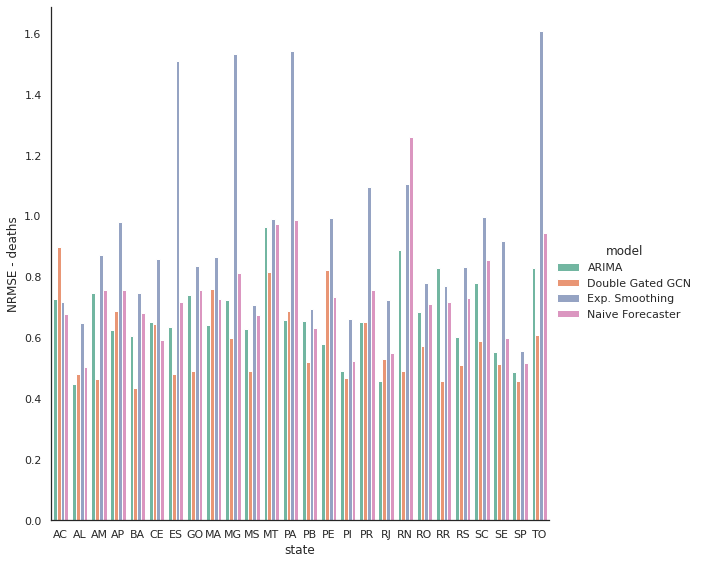

In [23]:
#f = (df['model'].str.contains(proposed)) & (df['state']!='DF')
f = (df['state']!='DF')
cat_order = list(set(df[f]['state'].values))
cat_order.sort()

for loss in LOSS.keys():
    for curve in CURVE:
        col = loss+'_'+curve
        label = loss+' - '+curve
        sns.catplot(
            x="state", 
            y=col,
            hue="model",
            kind="bar",
            order=cat_order,
            #palette='Set2',
            height=8,
            data=df[f]
        )
        plt.ylabel(label)
        plt.savefig(IMG_PATH+'state_'+col+'_[en].png', dpi=150)
        plt.show()

## C) By Forecasting Horizon

In [24]:
# força o garbage collector
gc.collect()

# vai expandir em 3 GB (base de dados completa) ou 
# 2 GB (base de dados resumida) durante a execução
df = calcMetrics(by='horizon', reduce=False).merge(VERTEX[['geocode','size_categ']], on='geocode')
df.rename(columns={'size_categ':'size'}, inplace=True)
df

,model,geocode,horizon,MAE_cases,MAE_deaths,sMAPE_cases,sMAPE_deaths,NRMSE_cases,NRMSE_deaths,size
0,ARIMA,1100015,1,0.182017,5.185604e-06,0.052234,1.728538e-06,0.004862,3.372652e-06,medium
1,ARIMA,1100015,1,0.258091,7.152557e-07,0.039156,2.384185e-07,0.006894,4.651934e-07,medium
2,ARIMA,1100015,1,0.226415,5.066395e-06,0.019791,1.688801e-06,0.006048,3.295120e-06,medium
3,ARIMA,1100015,1,6.277255,6.953955e-03,0.312985,2.312624e-03,0.167679,4.522765e-03,medium
4,ARIMA,1100015,1,5.535713,1.381630e-01,0.357968,3.631253e-02,0.147871,8.985946e-02,medium
...,...,...,...,...,...,...,...,...,...,...
5569995,Naive Forecaster,5300108,25,4.999939,1.033333e+01,0.003858,2.384615e-01,0.130846,8.053071e+00,large
5569996,Naive Forecaster,5300108,25,230.000000,4.666666e+00,0.214753,1.647059e-01,6.019008,3.636870e+00,large
5569997,Naive Forecaster,5300108,25,239.000061,3.333333e+00,0.221296,1.639344e-01,6.254535,2.597764e+00,large
5569998,Naive Forecaster,5300108,25,101.000061,3.333333e+00,0.082923,1.639344e-01,2.643131,2.597764e+00,large


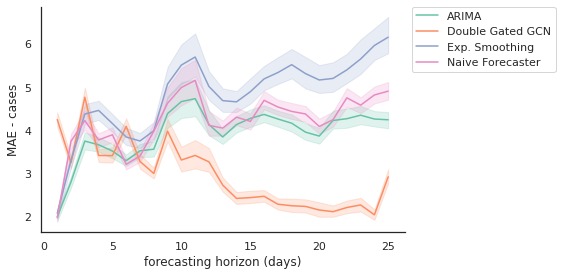

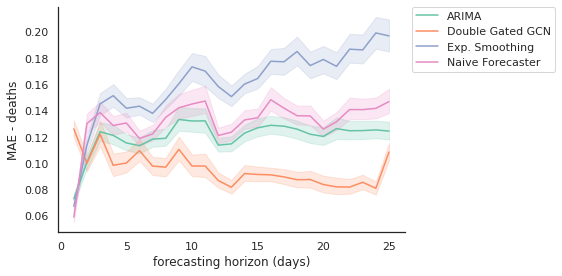

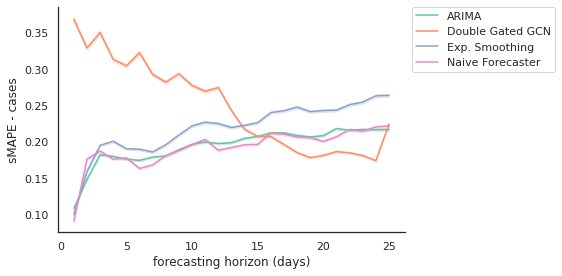

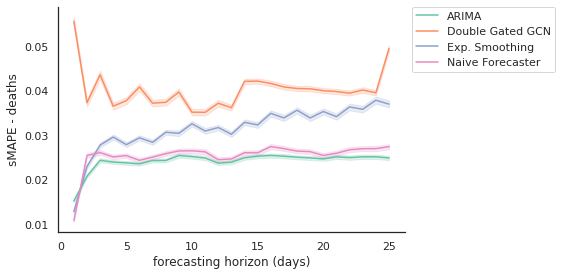

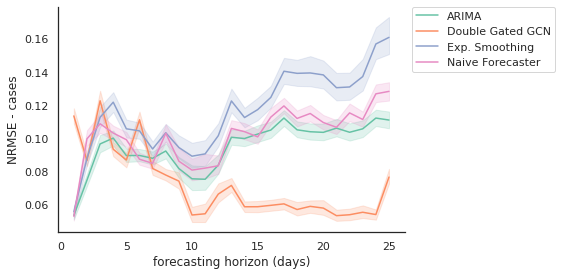

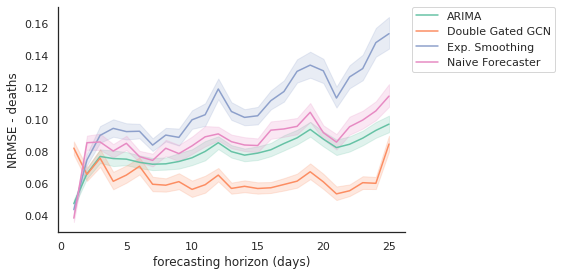

In [ ]:
# comparação dos modelos para as curvas de casos
for loss in LOSS.keys():
    for curve in CURVE:
        col = loss+'_'+curve
        label = loss+' - '+curve
        sns.lineplot(
            x="horizon", 
            y=col,
            hue="model",
            ci=95,
            #style="event",
            palette='Set2',
            data=df
        )
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.xlabel('forecasting horizon (days)')
        plt.ylabel(label)
        plt.tight_layout()
        plt.savefig(IMG_PATH+'horizon_'+col+'_[en].png', dpi=150)
        plt.show()

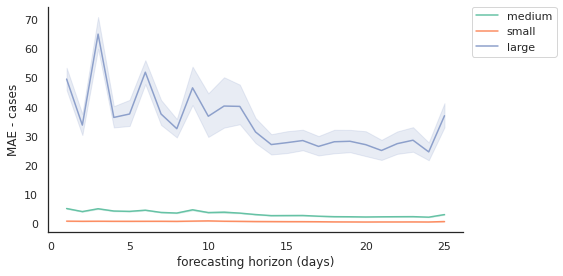

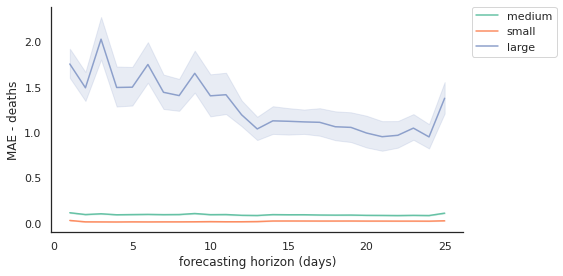

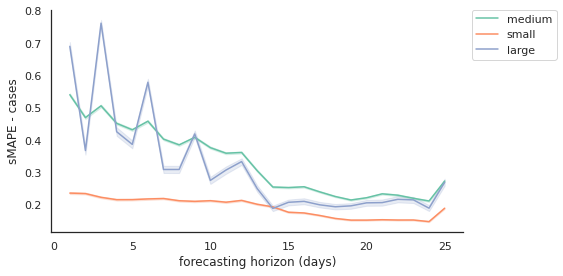

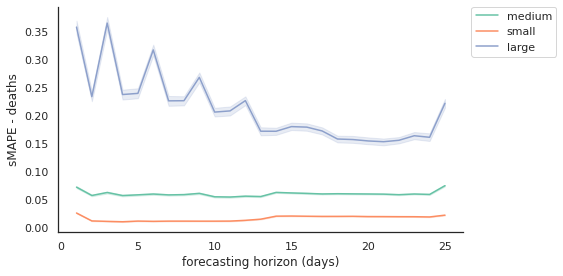

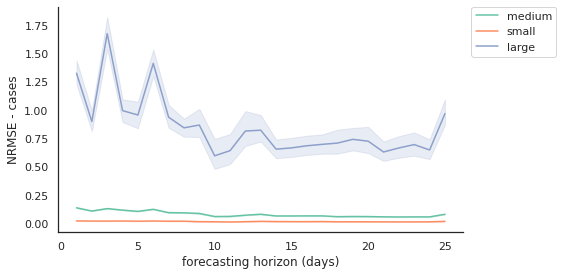

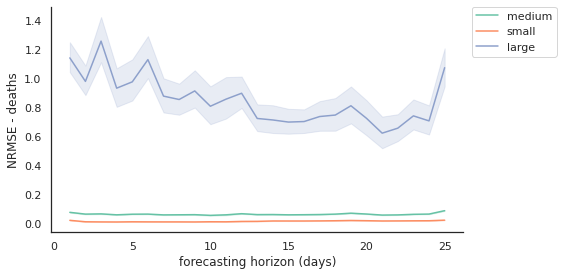

In [ ]:
# desempenho por tamanho para as curvas de casos e mortes
for loss in LOSS.keys():
    for curve in CURVE:
        col = loss+'_'+curve
        label = loss+' - '+curve
        sns.lineplot(
            x="horizon", 
            y=col,
            hue="size",
            #style='model',
            ci=95,
            palette='Set2',
            data=df[ df['model'].str.contains(proposed) ]
        )
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.xlabel('forecasting horizon (days)')
        plt.ylabel(label)
        plt.tight_layout()
        plt.savefig(IMG_PATH+'horizon-size_'+col+'_[en].png', dpi=150)
        plt.show()

## D) By Model

In [ ]:
# força o garbage collector
gc.collect()
df = calcMetrics(by='model', reduce=False)

# Statistic Tests

## A) By Fold

In [26]:
df = calcMetrics(by='fold')
df

,model,fold,MAE_cases,MAE_deaths,sMAPE_cases,sMAPE_deaths,NRMSE_cases,NRMSE_deaths
0,ARIMA,1,2.877742,0.115627,0.138988,0.018071,0.643022,0.420755
1,ARIMA,2,4.273767,0.131745,0.195191,0.022995,0.573186,0.501014
2,ARIMA,3,4.364729,0.139754,0.199500,0.027273,0.514397,0.476743
3,ARIMA,4,4.431896,0.140375,0.201838,0.028097,0.598309,0.547616
4,ARIMA,5,3.436874,0.119146,0.181369,0.025262,0.623094,0.579251
5,ARIMA,6,2.831670,0.105649,0.176619,0.023348,0.625463,0.603354
6,ARIMA,7,2.634652,0.095363,0.182845,0.021616,0.620093,0.922455
7,ARIMA,8,4.552767,0.109341,0.209426,0.022748,0.814738,0.775116
8,ARIMA,9,4.705326,0.116555,0.222470,0.025838,0.744449,0.564212
9,ARIMA,10,5.206690,0.132006,0.234003,0.026871,0.589491,0.597870


Performs the two-sample [Kolmogorov-Smirnov test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest) for goodness or fit, with null hypotesis **H0** being **the two distributions are identic**. Steps for each model, metric and curve:

- Obtain the average error across the folds (observation)
- Generate a normal distribution with the same mean and std of the observation
- Check the fitness of the observation to the normal distribution

In [27]:
def checkNormality(df, alpha, qt_tests=10):
    rng = np.random.default_rng()

    for m in LOSS.keys():
        for c in CURVE:
            col = m+'_'+c
            print(f'\n<<< {col} >>>\n')

            for f in set(df['model']):
                obs = df[ df['model']==f ][col].values
                s = p = 0.0

                for i in range(qt_tests):
                    norm = sts.norm.rvs(loc=obs.mean(), scale=obs.std(), size=len(obs), random_state=rng)
                    si,pi = sts.kstest(obs, norm)
                    s += si
                    p += pi

                s /= qt_tests
                p /= qt_tests
                res = 'x' if (p <= alpha) else ' '
                print(f'[{res}]  {f:16s} :  statistic = {s:8.6f}  |  p-value = {p:8.6f}')
    return

In [28]:
# H0: the two distributions are identic
#====================================================
# an [x] mark means that H0 was rejected and the
# observations doesn't follow a normal distribution

checkNormality(df, 0.05, 50)


<<< MAE_cases >>>

[ ]  Double Gated GCN :  statistic = 0.352000  |  p-value = 0.602884
[ ]  Naive Forecaster :  statistic = 0.338000  |  p-value = 0.655342
[ ]  Exp. Smoothing   :  statistic = 0.326000  |  p-value = 0.679641
[ ]  ARIMA            :  statistic = 0.302000  |  p-value = 0.743085

<<< MAE_deaths >>>

[ ]  Double Gated GCN :  statistic = 0.294000  |  p-value = 0.758844
[ ]  Naive Forecaster :  statistic = 0.294000  |  p-value = 0.749131
[ ]  Exp. Smoothing   :  statistic = 0.318000  |  p-value = 0.695692
[ ]  ARIMA            :  statistic = 0.294000  |  p-value = 0.756450

<<< sMAPE_cases >>>

[ ]  Double Gated GCN :  statistic = 0.406000  |  p-value = 0.455234
[ ]  Naive Forecaster :  statistic = 0.300000  |  p-value = 0.735877
[ ]  Exp. Smoothing   :  statistic = 0.316000  |  p-value = 0.700393
[ ]  ARIMA            :  statistic = 0.290000  |  p-value = 0.767935

<<< sMAPE_deaths >>>

[ ]  Double Gated GCN :  statistic = 0.278000  |  p-value = 0.805842
[ ]  Naive Foreca

Performs [T-test for the means of two independent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind) samples of score, with the null hypotesis **H0** being **Loss(proposed model) <= Loss(baseline model)**. Steps for each metric and curve:

- Compare the observations of the baseline  with the proposed one

In [29]:
def checkHypothesis(df, alpha, targets):
    for t in targets:
        samplesProp = df[ df['model']==t ]

        for baseline in set(df['model']) - set(targets):
            print(f'\n<<< {t} x {baseline} >>>\n')
            samplesBase = df[ df['model']==baseline ]

            for m in LOSS.keys():
                for c in CURVE:
                    col = m+'_'+c
                    x1 = samplesBase[col].values
                    x2 = samplesProp[col].values
                    s,p = sts.ttest_ind(x1, x2, alternative='greater')
                    res = 'x' if (p <= alpha) else ' '
                    print(f'[{res}]  {col:12s} :  statistic = {s:10.6f}  |  p-value = {p:8.6f}')

In [31]:
# H0: Loss(baseline) <= Loss(proposed)
#====================================================
# the [x] mark means that H0 was rejected and the
# baseline has greater error than the proposed model

checkHypothesis(df, 0.05, [proposed])


<<< Double Gated GCN x Naive Forecaster >>>

[x]  MAE_cases    :  statistic =   3.254766  |  p-value = 0.002199
[x]  MAE_deaths   :  statistic =   5.174018  |  p-value = 0.000032
[ ]  sMAPE_cases  :  statistic =  -2.936270  |  p-value = 0.995587
[ ]  sMAPE_deaths :  statistic =  -4.175692  |  p-value = 0.999716
[x]  NRMSE_cases  :  statistic =   2.578005  |  p-value = 0.009477
[x]  NRMSE_deaths :  statistic =   2.636319  |  p-value = 0.008383

<<< Double Gated GCN x Exp. Smoothing >>>

[x]  MAE_cases    :  statistic =   4.675028  |  p-value = 0.000094
[x]  MAE_deaths   :  statistic =   6.281278  |  p-value = 0.000003
[ ]  sMAPE_cases  :  statistic =  -1.787368  |  p-value = 0.954636
[ ]  sMAPE_deaths :  statistic =  -1.457622  |  p-value = 0.918914
[x]  NRMSE_cases  :  statistic =   3.311871  |  p-value = 0.001939
[x]  NRMSE_deaths :  statistic =   3.960935  |  p-value = 0.000458

<<< Double Gated GCN x ARIMA >>>

[x]  MAE_cases    :  statistic =   2.805018  |  p-value = 0.005855
[x] 